In [1]:
import _init_paths
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes
from Evaluator import *
from utils import *
from imutils import paths

In [2]:
def getBoundingBoxes(gtPath, detPath, comics=False):
    """Read txt files containing bounding boxes (ground truth and detections)."""
    allBoundingBoxes = BoundingBoxes()
    import glob
    import os
    # Read ground truths
    #currentPath = os.path.dirname(os.path.abspath(__file__))
    folderGT = gtPath#os.path.join(currentPath, gtPath)
#     os.chdir(folderGT)
#     files = glob.glob("*.txt")
    files = list(paths.list_files(folderGT))
    files.sort()
#     print(files)
    # Class representing bounding boxes (ground truths and detections)
    allBoundingBoxes = BoundingBoxes()
    # Read GT detections from txt file
    # Each line of the files in the groundtruths folder represents a ground truth bounding box
    # (bounding boxes that a detector should detect)
    # Each value of each line is  "class_id, x, y, width, height" respectively
    # Class_id represents the class of the bounding box
    # x, y represents the most top-left coordinates of the bounding box
    # x2, y2 represents the most bottom-right coordinates of the bounding box
    for f in files:
        p1, p2 = f.split('/')[-2:]
        imageName = p2.split('.')[0]
        nameOfImage = '{}/{}'.format(p1,imageName)
        
        if not comics:
            nameOfImage = imageName
        
        fh1 = open(f, "r")
        for line in fh1:
            line = line.replace("\n", "")
            if line.replace(' ', '') == '':
                continue
#             print(line)
            splitLine = line.split(" ")
            idClass = splitLine[0]  # class
            x = float(splitLine[1])  # confidence
            y = float(splitLine[2])
            w = float(splitLine[3])
            h = float(splitLine[4])
            bb = BoundingBox(
                nameOfImage,
                idClass,
                x,
                y,
                w,
                h,
                CoordinatesType.Absolute, (200, 200),
                BBType.GroundTruth,
                format=BBFormat.XYWH)
            allBoundingBoxes.addBoundingBox(bb)
        fh1.close()
    # Read detections
    folderDet = detPath#os.path.join(currentPath, detPath)
#     os.chdir(folderDet)
#     files = glob.glob("*.txt")
    files = list(paths.list_files(folderDet))
    files.sort()
#     print(files)
    # Read detections from txt file
    # Each line of the files in the detections folder represents a detected bounding box.
    # Each value of each line is  "class_id, confidence, x, y, width, height" respectively
    # Class_id represents the class of the detected bounding box
    # Confidence represents confidence (from 0 to 1) that this detection belongs to the class_id.
    # x, y represents the most top-left coordinates of the bounding box
    # x2, y2 represents the most bottom-right coordinates of the bounding box
    for f in files:
        # nameOfImage = f.replace("_det.txt","")
#         nameOfImage = f.replace(".txt", "")
        p1, p2 = f.split('/')[-2:]
        imageName = p2.split('.')[0]
        nameOfImage = '{}/{}'.format(p1,imageName)

        if not comics:
            nameOfImage = imageName
            
        # Read detections from txt file
        fh1 = open(f, "r")
        for line in fh1:
            line = line.replace("\n", "")
#             print(line)
            if line.replace(' ', '') == '':
                continue
            splitLine = line.split(" ")
            idClass = splitLine[0]  # class
            confidence = float(splitLine[1])  # confidence
            x = float(splitLine[2])
            y = float(splitLine[3])
            w = float(splitLine[4])
            h = float(splitLine[5])
            bb = BoundingBox(
                nameOfImage,
                idClass,
                x,
                y,
                w,
                h,
                CoordinatesType.Absolute, (200, 200),
                BBType.Detected,
                confidence,
                format=BBFormat.XYWH)
            allBoundingBoxes.addBoundingBox(bb)
        fh1.close()
    return allBoundingBoxes

In [3]:
def createImages(dictGroundTruth, dictDetected):
    """Create representative images with bounding boxes."""
    import numpy as np
    import cv2
    # Define image size
    width = 200
    height = 200
    # Loop through the dictionary with ground truth detections
    for key in dictGroundTruth:
        image = np.zeros((height, width, 3), np.uint8)
        gt_boundingboxes = dictGroundTruth[key]
        image = gt_boundingboxes.drawAllBoundingBoxes(image)
        detection_boundingboxes = dictDetected[key]
        image = detection_boundingboxes.drawAllBoundingBoxes(image)
        # Show detection and its GT
        cv2.imshow(key, image)
        cv2.waitKey()

In [4]:
def evaluate(gt, dt, comics=False):
    # Read txt files containing bounding boxes (ground truth and detections)
    boundingboxes = getBoundingBoxes(gt, dt, comics)

    # Uncomment the line below to generate images based on the bounding boxes
    # createImages(dictGroundTruth, dictDetected)
    # Create an evaluator object in order to obtain the metrics
    evaluator = Evaluator()
    ##############################################################
    # VOC PASCAL Metrics
    ##############################################################
    
    # Plot Precision x Recall curve
    evaluator.PlotPrecisionRecallCurve(
        boundingboxes,  # Object containing all bounding boxes (ground truths and detections)
        IOUThreshold=iou,  # IOU threshold
        method=MethodAveragePrecision.EveryPointInterpolation,  # As the official matlab code
        showAP=True,  # Show Average Precision in the title of the plot
        showInterpolatedPrecision=True)  # Plot the interpolated precision curve

    # Get metrics with PASCAL VOC metrics
    metricsPerClass = evaluator.GetPascalVOCMetrics(
        boundingboxes,  # Object containing all bounding boxes (ground truths and detections)
        IOUThreshold=iou,  # IOU threshold
        method=MethodAveragePrecision.EveryPointInterpolation)  # As the official matlab code
    print("Average precision values per class:\n")

    # Loop through classes to obtain their metrics
    for mc in metricsPerClass:
        # Get metric values per each class
        c = mc['class']
        precision = mc['precision']
        recall = mc['recall']
        average_precision = mc['AP']
        ipre = mc['interpolated precision']
        irec = mc['interpolated recall']
    
        # Print AP per class
        print('%s: %f' % (c, average_precision))
        print("Precision: {}, Recall: {}".format(precision[-1], recall[-1]))

In [5]:
exp_id = 999    # Experiment ID   
iou = 0.5       # IoU threshold
aug = 1         # The number of image sizes

/workspace/yolov5-face/Object-Detection-Metrics/results/exp_402/pets/detections_30_1/


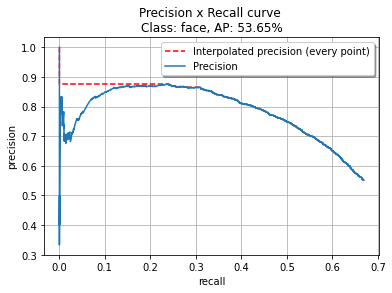

Average precision values per class:

face: 0.536504
Precision: 0.551184622261958, Recall: 0.6688364524003255


In [15]:
pets_gt = '/workspace/dataset/pets/labels_eval/'    # ground truth directory
pets_dt = '/workspace/yolov5-face/Object-Detection-Metrics/results/external/exp_{}/pets/detections_{}_{}/'.format(
    exp_id, int(iou*100), aug)
print(pets_dt)                                      # detection directory

evaluate(pets_gt, pets_dt)

/workspace/yolov5-face/Object-Detection-Metrics/results/exp_402/birds/detections_30_1/


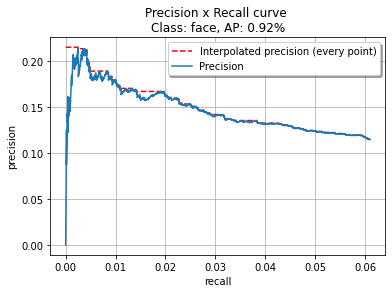

Average precision values per class:

face: 0.009163
Precision: 0.11452691940108314, Recall: 0.06099423142178487


In [16]:
birds_gt = '/workspace/dataset/birds/labels_eval/'
birds_dt = '/workspace/yolov5-face/Object-Detection-Metrics/results/external/exp_{}/birds/detections_{}_{}/'.format(
    exp_id, int(iou*100), aug)
print(birds_dt)

evaluate(birds_gt, birds_dt)

/workspace/yolov5-face/Object-Detection-Metrics/results/external/exp_999/artisticfaces/detections_50_1/


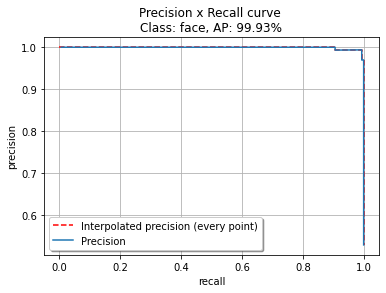

Average precision values per class:

face: 0.999264
Precision: 0.528052805280528, Recall: 1.0


In [6]:
art_gt = '/workspace/dataset/artisticfaces/labels_eval/'
art_dt = '/workspace/yolov5-face/Object-Detection-Metrics/results/external/exp_{}/artisticfaces/detections_{}_{}/'.format(
    exp_id, int(iou*100), aug)
print(art_dt)

evaluate(art_gt, art_dt)

/workspace/yolov5-face/Object-Detection-Metrics/results/exp_402/metfaces/detections_30_1/


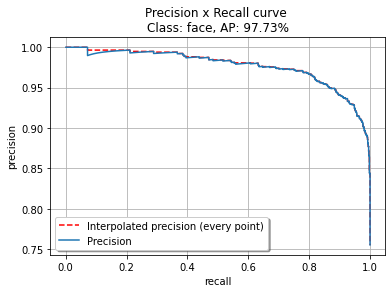

Average precision values per class:

face: 0.977305
Precision: 0.7552289429055964, Recall: 1.0


In [18]:
met_gt = '/workspace/dataset/metfaces/labels_eval/'
met_dt = '/workspace/yolov5-face/Object-Detection-Metrics/results/external/exp_{}/metfaces/detections_{}_{}/'.format(
    exp_id, int(iou*100), aug)
print(met_dt)

evaluate(met_gt, met_dt)

/workspace/yolov5-face/Object-Detection-Metrics/results/exp_402/turtles/detections_30_1/


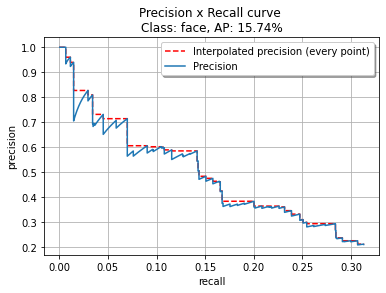

Average precision values per class:

face: 0.157367
Precision: 0.208955223880597, Recall: 0.3128863528292915


In [19]:
turtles_gt = '/workspace/dataset/turtles/labels_eval/'
turtles_dt = '/workspace/yolov5-face/Object-Detection-Metrics/results/external/exp_{}/turtles/detections_{}_{}/'.format(
    exp_id, int(iou*100), aug)
print(turtles_dt)

evaluate(turtles_gt, turtles_dt)

/workspace/yolov5-face/Object-Detection-Metrics/results/exp_402/animefaces/detections_30_1/


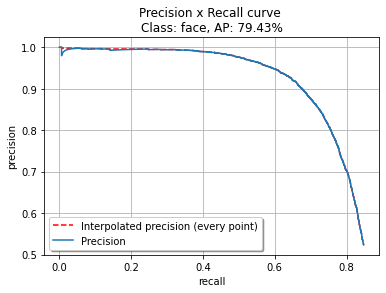

Average precision values per class:

face: 0.794269
Precision: 0.5231230258362355, Recall: 0.8474153765415902


In [20]:
anime_gt = '/workspace/dataset/animefaces/labels_eval/'
anime_dt = '/workspace/yolov5-face/Object-Detection-Metrics/results/external/exp_{}/animefaces/detections_{}_{}/'.format(
    exp_id, int(iou*100), aug)
print(anime_dt)

evaluate(anime_gt, anime_dt)